In [8]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

from nltk import ngrams
import numpy as np
import json
import random
from typing import List, Tuple
import matplotlib.pyplot as plt

In [30]:
MODELS_INFO = {
    'gpt2-large': {
        'recurring': 'recurring__gsm8k__gpt2-large__output.json',
        'greedy': 'greedy__gsm8k__gpt2-large__output.json',
        'baseline': 'baseline__gsm8k__gpt2-large__output.json',
    },
    'gemma-2b': {
        'recurring': 'recurring__gsm8k__gemma-2b__output.json',
        'greedy': 'greedy__gsm8k__gemma-2b__output.json',
        'baseline': 'baseline__gsm8k__gemma-2b__output.json',
    },
    'gemma-7b': {
        'recurring':'recurring__gsm8k__gemma-7b__output.json',
        'greedy': 'greedy__gsm8k__gemma-7b__output.json',
        'baseline': 'baseline__gsm8k__gemma-7b__output.json',
    },
}

METHODS = ['recurring',  'baseline']

MAJORITY_THRESHOLD = 0.5

NUM_SAMPLES = [8, 16, 24]

RECURRING_TIMESTEPS = 3

In [31]:
def compute_n_gram_diversity(qa_generations: List[object], subsample_size: int = -1) -> float:
    """Compute the n-gram diversity for the QA generation output

    Args:
        qa_generations (List[object]): List of question-answer generation outputs

    Returns:
        float: n-gram diversity for 1-4 grams
    """
    n_gram_diversity = 0.0
    # Compute the n-gram diversity for 1-4 grams
    # Subsample the generated sequences
    sentences = qa_generations[:subsample_size]
    # Compute the n-gram diversity for the QA generation
    qa_n_gram_diversity = distinct_n_gram_helper(sentences)
    n_gram_diversity += qa_n_gram_diversity
    # Return the n-gram diversity
    return n_gram_diversity / len(qa_generations)


def distinct_n_gram_helper(sentences: List[str]):
    """Compute distinct-n for n in [1,4] a list of sentences
    Args:
        sentences (List[str]): a list of sentences
    
    Returns:
        float: distinct-n score for n in [1,4]
    """
    # Initialize the distinct-n score
    total_unique_ngrams = 0
    n_gram_diversity = 0.0
    # Compute the distinct-n score for n in [1,4]
    for n in range(1, 5):
        unique_ngrams = set()
        total_ngrams_count = 0
        for sequence in sentences:
            n_grams = list(ngrams(sequence.split(), n))
            unique_ngrams.update(n_grams)
            total_ngrams_count += len(n_grams)
        total_unique_ngrams = len(unique_ngrams)
        n_gram_diversity += total_unique_ngrams / (total_ngrams_count + np.finfo(float).eps)
    return n_gram_diversity

In [32]:
def get_n_gram_diversity(model_name, method, num_samples):
    if MODELS_INFO[model_name][method] is None:
        return 0
    file = os.path.join('../../results/', MODELS_INFO[model_name][method])
    output = json.load(open(file))
    
    if method == 'recurring':
        n_div, total = 0, 0
        for inst in output:
            gen_seq = []
            time_steps = num_samples//8
            if len(inst['generated_sequences']) < time_steps:
                continue
            for i in range(time_steps):
                gen_seq += inst['generated_sequences'][i]
            n_div += compute_n_gram_diversity(gen_seq, num_samples)
            total += 1
        return n_div / total
    elif method == 'baseline':
        n_div, total = 0, 0
        for inst in output:
            n_div += compute_n_gram_diversity(inst['generated_sequences'], num_samples)
        return n_div / len(output)
    elif method == 'greedy':
        n_div, total = 0, 0
        for inst in output:
            n_div += compute_n_gram_diversity(inst['generated_sequences'], 1)
        return n_div / len(output)
    raise ValueError('Invalid method')

In [33]:
plot_df = pd.DataFrame(columns=['Model', 'Method', 'Number of Samples', 'N-Gram Diversity'])

for model_name in MODELS_INFO:
    for method in METHODS:
        for num_samples in NUM_SAMPLES:
            print(f"Model: {model_name}, Method: {method}, Number of Samples: {num_samples}")
            n_gram = get_n_gram_diversity(model_name, method, num_samples)
            plot_df = pd.concat([plot_df, pd.DataFrame([{
                'Model': model_name,
                'Method': f"RCS (Our Approach)" if method == 'recurring' else 'Greedy' if method == 'greedy' else 'Self-Consistancy',
                'Number of Samples': num_samples,
                'N-Gram Diversity': n_gram
            }])], ignore_index=True)

Model: gpt2-large, Method: recurring, Number of Samples: 8


C:\Users\AADAM\AppData\Local\Temp\ipykernel_52908\4258919843.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, pd.DataFrame([{


Model: gpt2-large, Method: recurring, Number of Samples: 16
Model: gpt2-large, Method: recurring, Number of Samples: 24
Model: gpt2-large, Method: baseline, Number of Samples: 8
Model: gpt2-large, Method: baseline, Number of Samples: 16
Model: gpt2-large, Method: baseline, Number of Samples: 24
Model: gemma-2b, Method: recurring, Number of Samples: 8
Model: gemma-2b, Method: recurring, Number of Samples: 16
Model: gemma-2b, Method: recurring, Number of Samples: 24
Model: gemma-2b, Method: baseline, Number of Samples: 8
Model: gemma-2b, Method: baseline, Number of Samples: 16
Model: gemma-2b, Method: baseline, Number of Samples: 24
Model: gemma-7b, Method: recurring, Number of Samples: 8
Model: gemma-7b, Method: recurring, Number of Samples: 16
Model: gemma-7b, Method: recurring, Number of Samples: 24
Model: gemma-7b, Method: baseline, Number of Samples: 8
Model: gemma-7b, Method: baseline, Number of Samples: 16
Model: gemma-7b, Method: baseline, Number of Samples: 24


[]

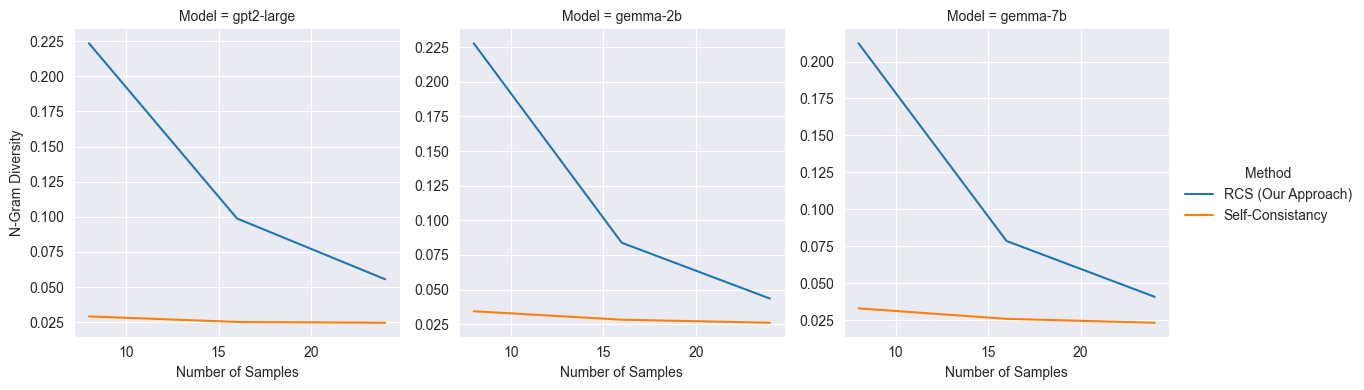

In [34]:
sns.set_style("darkgrid")
g = sns.FacetGrid(plot_df, col="Model", hue="Method", sharey=False, height=4)
g.map(sns.lineplot,'Number of Samples','N-Gram Diversity', markers=True)
g.add_legend()
plt.plot()